In [2]:
# Imports
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


data = pd.read_sql_query("SELECT * FROM 'mortgage complaints'", "sqlite:///StaterData.db")

# Drop dates for testing purposes
# data.drop(['Date received', 'Date sent to company'], axis=1)

#Limit test size due to performance issues
data = data.loc[:25000]

In [3]:
data[['Consumer complaint narrative', 'Issue']].head()

,Consumer complaint narrative,Issue
0,We had some hardships between COVID and some m...,Trouble during payment process
1,My mortgage was sold to Roundpoint company in ...,Trouble during payment process
2,PHH automatically enrolled me into a COVID For...,Struggling to pay mortgage
3,"Hello, my name is XXXX XXXX. So 12 months ago ...",Trouble during payment process
4,I have spoken with this company on the followi...,Applying for a mortgage or refinancing an exis...


In [4]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize your text data using a bag-of-words approach
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1score = f1_score(y_test, y_pred, average='macro')
print('F1 score:', f1score)


Accuracy: 0.6548460205305959
F1 score: 0.18866466672535917


In [5]:
# Process and transform custom text for prediction
custom_text = "My mortgage was sold to Roundpoint company in XX/XX/2023. I got a letter in XXXX from my prior lender, XXXX XXXX stating this was to occur and the next payment to be made would go to Roundpoint. X..."
custom_text_bow = vectorizer.transform([custom_text])

# Predict the issue for the custom text data
predicted_issue = rf_model.predict(custom_text_bow)

# Print the predicted issue
print('Predicted issue:', predicted_issue)


Predicted issue: ['Trouble during payment process']


['Trouble during payment process' 'Struggling to pay mortgage'
 'Applying for a mortgage or refinancing an existing mortgage'
 'Closing on a mortgage' 'Settlement process and costs'
 'Application, originator, mortgage broker'
 'Loan modification,collection,foreclosure'
 'Loan servicing, payments, escrow account'
 'Incorrect information on your report'
 'Unable to get your credit report or credit score'
 'Improper use of your report' 'Credit decision / Underwriting'
 "Problem with a credit reporting company's investigation into an existing problem"
 'Credit monitoring or identity theft protection services'
 'Problem with fraud alerts or security freezes']


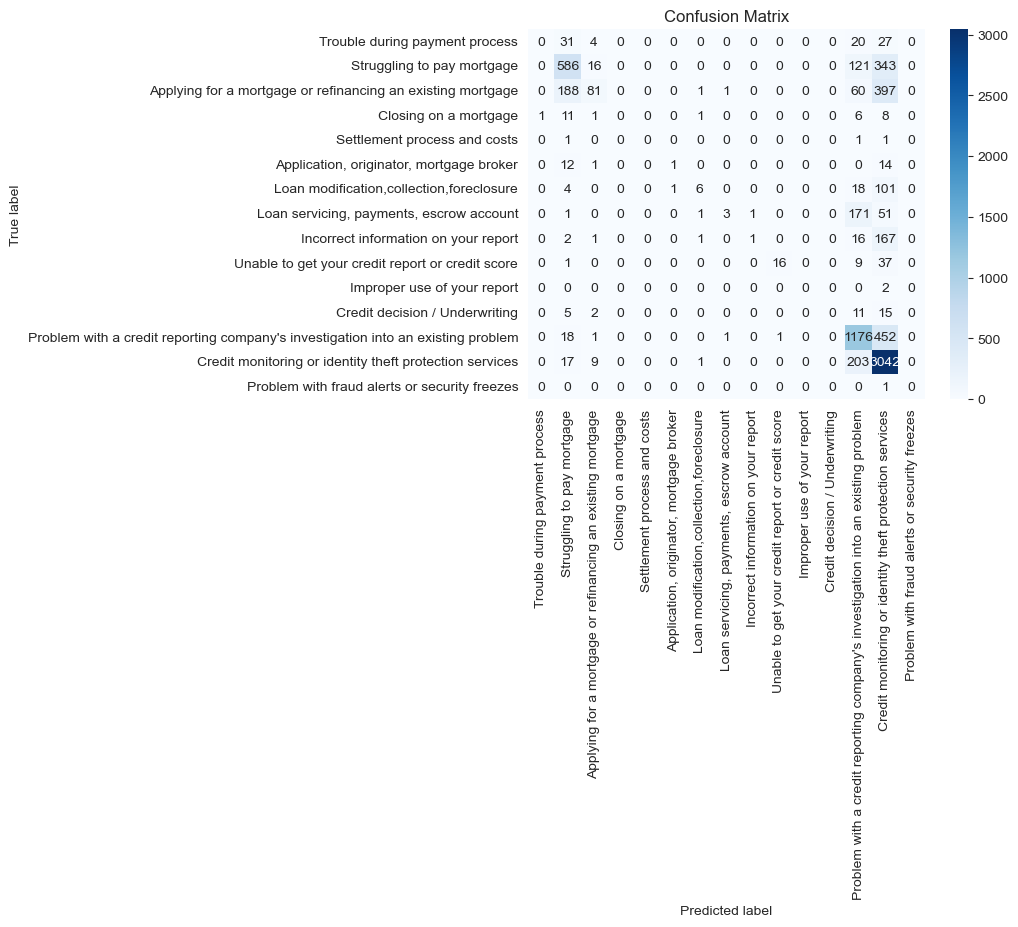

In [6]:
# make predictions on test data using trained model
y_pred = rf_model.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create labels for xticklabels
labels = data['Issue'].unique()
print(labels)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

In [7]:
# Create a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Print the DataFrame
print(df)



                                                    precision    recall  \
Application, originator, mortgage broker             0.000000  0.000000   
Applying for a mortgage or refinancing an exist...   0.668187  0.549719   
Closing on a mortgage                                0.698276  0.111264   
Credit decision / Underwriting                       0.000000  0.000000   
Credit monitoring or identity theft protection ...   0.000000  0.000000   
Improper use of your report                          0.500000  0.035714   
Incorrect information on your report                 0.545455  0.046154   
Loan modification,collection,foreclosure             0.600000  0.013158   
Loan servicing, payments, escrow account             0.500000  0.005319   
Problem with a credit reporting company's inves...   0.941176  0.253968   
Problem with fraud alerts or security freezes        0.000000  0.000000   
Settlement process and costs                         0.000000  0.000000   
Struggling to pay mortgag

Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


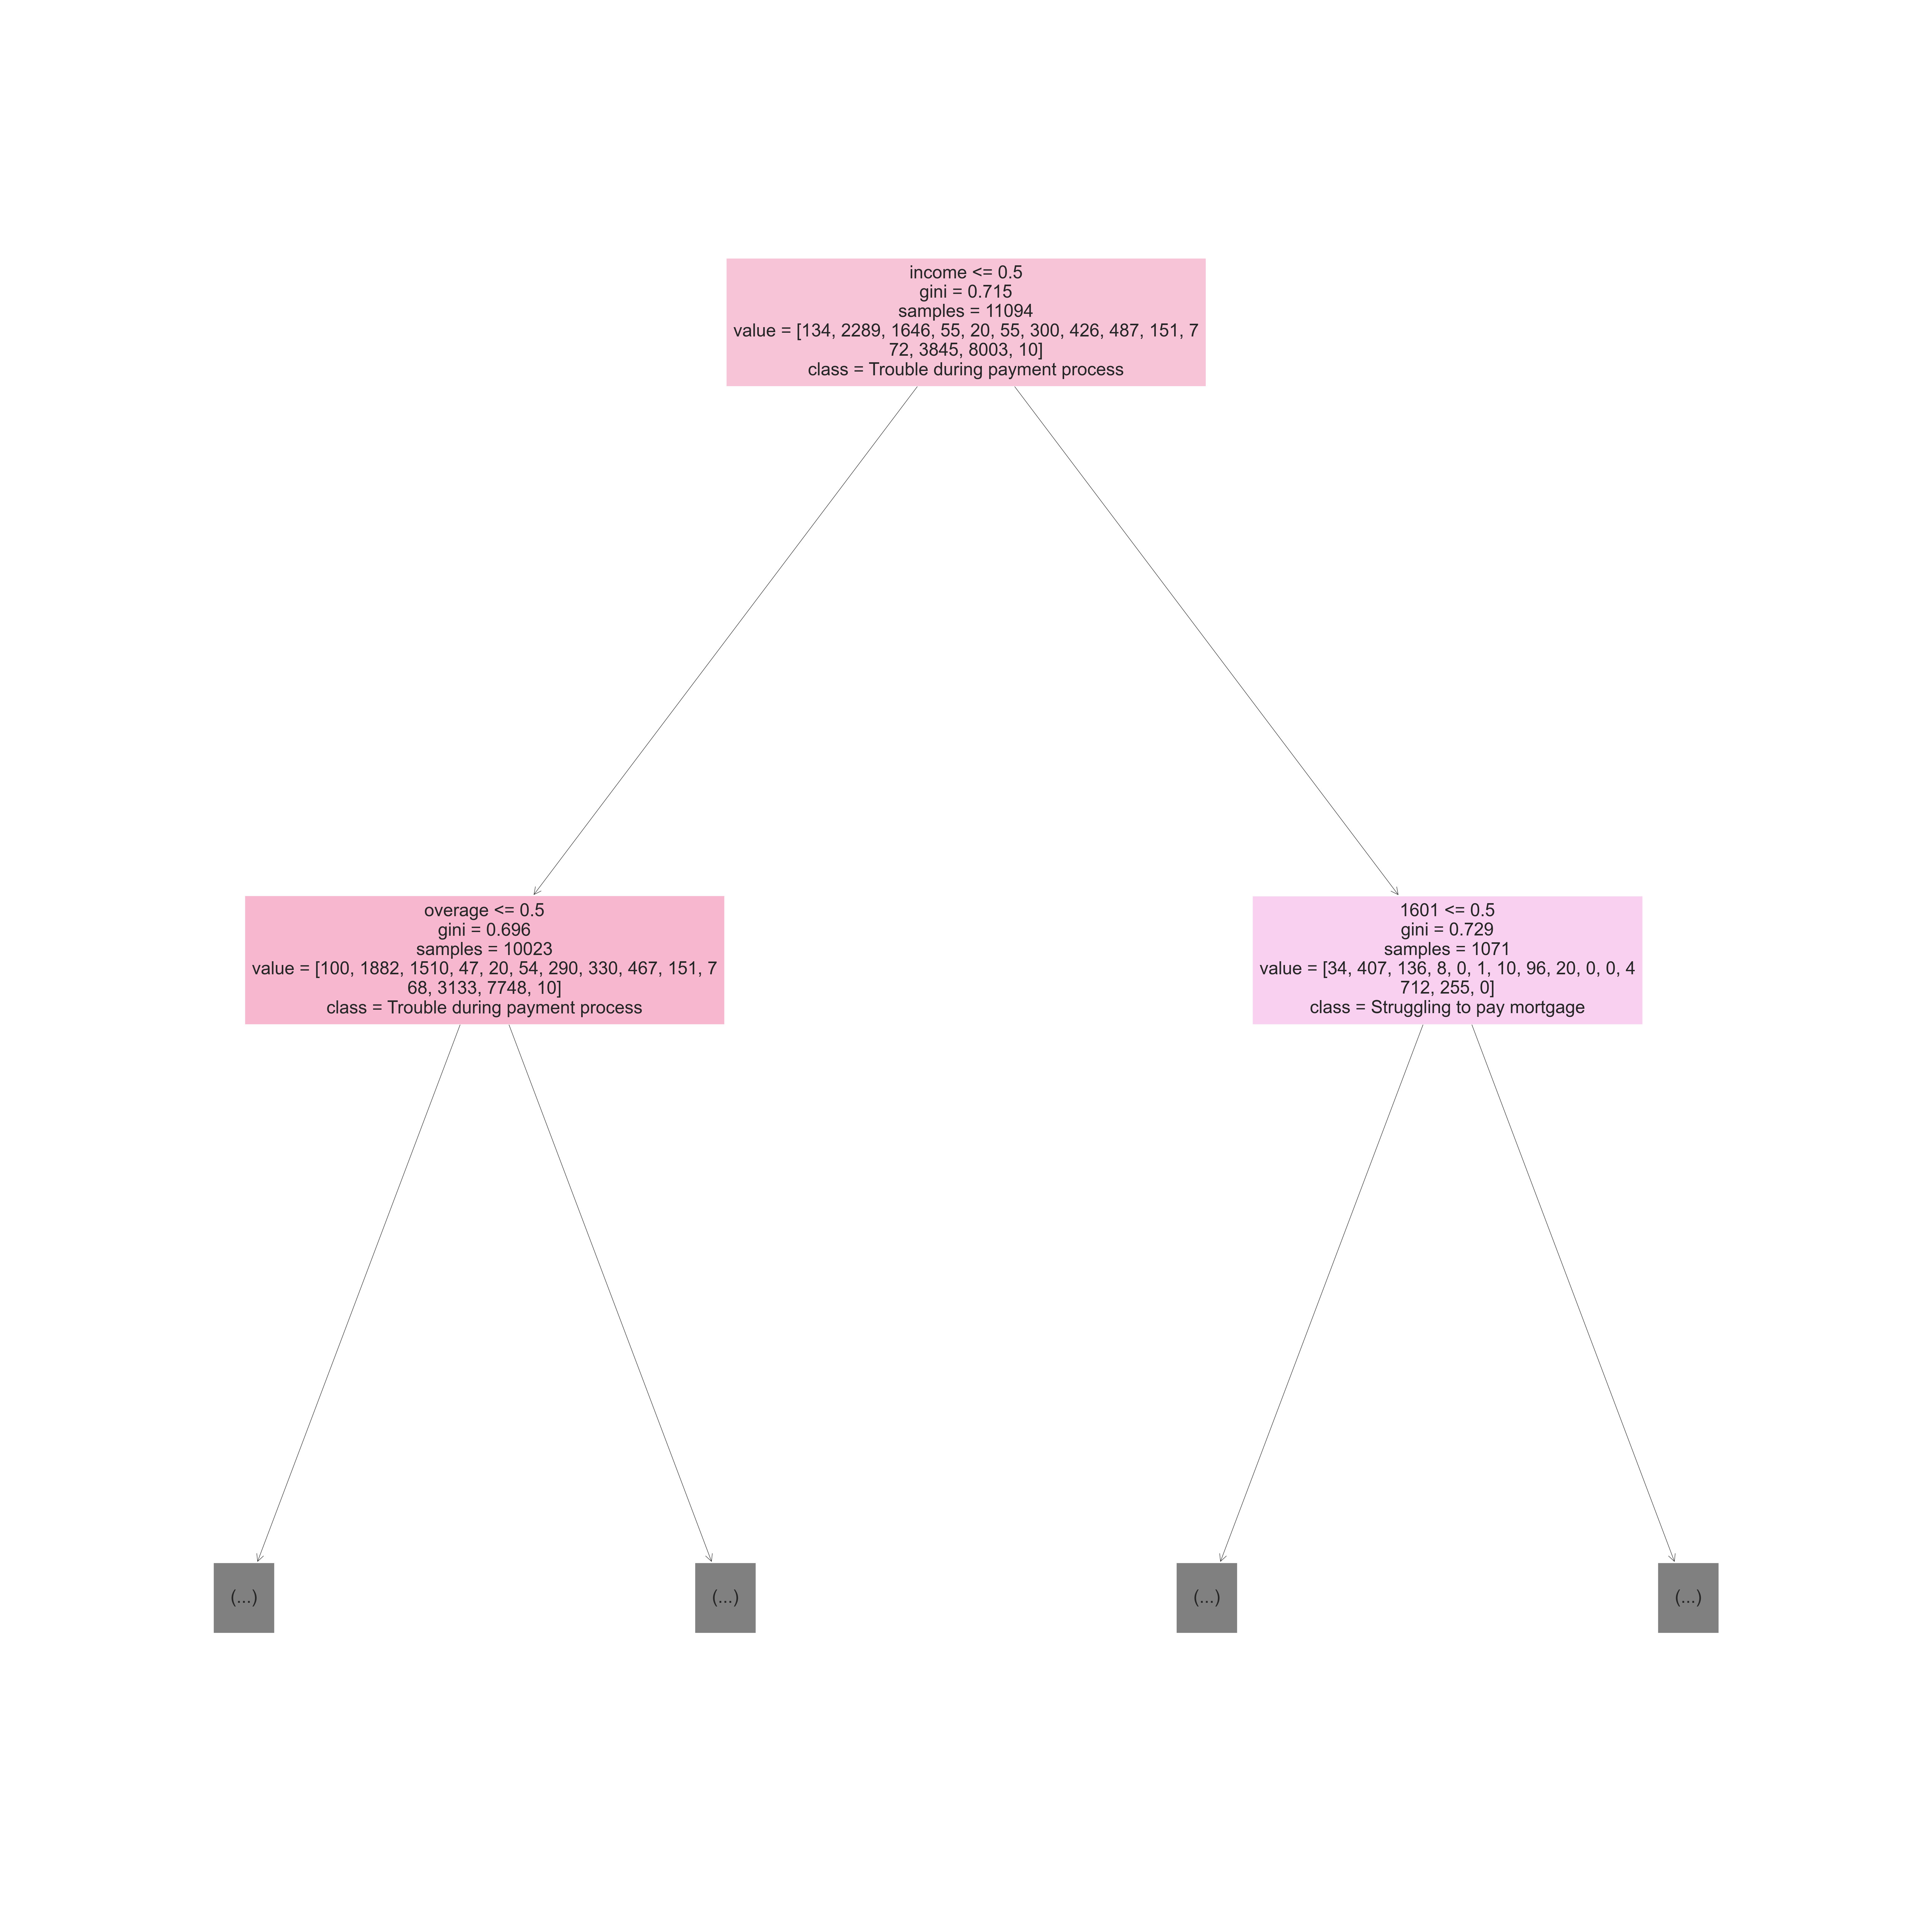

In [8]:
# Visualize the first tree in the Random Forest
plt.figure(figsize=(80, 80))

plot_tree(rf_model.estimators_[0], feature_names=vectorizer.get_feature_names_out(), class_names=rf_model.classes_, filled=True, max_depth=1)
plt.show()


In [9]:
formatted_accuracy = str(int(accuracy*100))
joblib.dump(rf_model, 'rf_model ' + formatted_accuracy + '%.joblib')
print(formatted_accuracy)

65


In [10]:
#Load the saved model from the file
#loaded_model = joblib.load('rf_model 70%.joblib')


In [17]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize your text data using a bag-of-words approach
vectorizer = CountVectorizer(stop_words=['english'])
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': vectorizer.get_feature_names(), 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print the 10 most important features
print(feature_importances.head(25))

top_features = feature_importances.head(10)['feature'].values.tolist()


            feature  importance
17694  modification    0.010469
19938       payment    0.006921
2189        account    0.006300
6262        closing    0.006157
10584        escrow    0.005510
12043   foreclosure    0.005393
22544     refinance    0.004637
3423    application    0.004601
27060           the    0.004442
27481            to    0.004356
30105          xxxx    0.004113
3155            and    0.003961
19657          paid    0.003864
16428          loan    0.003853
18098            my    0.003815
11939   forbearance    0.003746
19949      payments    0.003685
7719         credit    0.003539
15025     insurance    0.003530
24031          sale    0.003497
30103            xx    0.003433
0                00    0.003429
14337            in    0.003242
18958            of    0.003134
27188          they    0.003106


Z:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize your text data using a bag-of-words approach
vectorizer = CountVectorizer(stop_words='english', vocabulary=top_features)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1score = f1_score(y_test, y_pred, average='macro')
print('F1 score:', f1score)

Accuracy: 0.5965871217171044
F1 score: 0.16148221721992545


In [ ]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # number of folds for cross-validation
    scoring='accuracy',
    # n_jobs=-1,  # use all available CPU cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', grid_search.best_params_)
print('Best accuracy score:', grid_search.best_score_)

In [ ]:
#max score parameter hyper tuning = 0.6569142857142858
#max score = 0.6548460205305959